# Исследование объявлений о продаже квартир

<font size="4">Оглавление</font>

[Описание задачи](#description)   
    
[Шаг 1. Открытие данных](#start)   
[Вывод по шагу 1](#start_conclusion)   

[Шаг 2. Предобработка данных](#preprocessing)   
* [2.1 Обработка значений, в которых нарушена логика](#illogic)    
* [2.2 Обработка пропущенных значений](#null)    
* [2.3 Приведение типов](#types)    
[Вывод по шагу 2](#preprocessing_conclusion)   

[Шаг 3. Добавление расчетных данных](#adding_data)    
[Вывод по шагу 3](#adding_data_conclusion)    

[Шаг 4. Исследовательский анализ данных](#analysis)    
* [4.1 Изучение числовых параметров](#numerical_parameter)    
* [4.2 Изучение времени продажи квартиры](#period)     
* [4.3 Изучение выбросов](#ejection)    
* [4.4 Доминантные факторы](#dominants)   
* [4.5 Изучение по населенным пунктам](#locality)    
* [4.6 Изучение предложения квартир](#distance)    
* [4.7 Изучение сегмента квартир в центре](#center)   
[Вывод по шагу 4](#analysis_conclusion)   

[Общий вывод](#total_conclusion)    

<a id='description'></a>
# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

In [3]:
#служебные справочники для построения графиков
dimension = {'last_price':'RUR', 'total_area':'sq.m', 'living_area_calc':'sq.m', 'kitchen_area_calc':'sq.m',\
             'rooms':'pcs', 'ceiling_height':'m', 'cityCenters_nearest':'m', 'cost_per_sq_m':'RUR'}
titles = {'last_price':'price', 'total_area':'total area', 'living_area_calc':'living area',\
          'kitchen_area_calc':'kitchen area', 'rooms':'rooms', 'ceiling_height':'ceiling height',\
         'cityCenters_nearest':'distance to city center', 'date_dayofweek':'day of week',\
          'date_month':'month', 'date_year':'year'}

<a id='start'></a>
### Шаг 1. Изучение общей информации

In [4]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

В 8 столбцах из 22 все значения присутствуют.
Пропущенные значения содержатся в 14 столбцах:
* ceiling_height (высота потолков) - 61,2% данных заполнены
* floors_total (этажей в доме) - 99,6% заполнены (не заполнены данные по 86 объектам)
* living_area (жилая площадь) - 92% данных заполнены
* is_apartment (апартаменты) - заполнены 11,7%
* kitchen_area (площадь кухни) - 90,4% заполнены
* balcony (число балконов) - 51,4% заполнены
* locality_name (название населённого пункта) - 99,8% заполнены (не заполнены данные по 49 объектам)
* airports_nearest (расстояние до ближайшего аэропорта) - 76,6% заполнены
* cityCenters_nearest (расстояние до центра города) - 76,7% заполнены
* parks_around3000 (число парков в радиусе 3 км) - 76,7% заполнены
* parks_nearest (расстояние до ближайшего парка) - 34,1% заполнены
* ponds_around3000 (число водоёмов в радиусе 3 км) - 76,7% заполнены
* ponds_nearest (расстояние до ближайшего водоёма) - 38,4% заполнены
* days_exposition (дней было размещено объявление) - 86,6% заполнены


In [5]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,nan,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,False,False,nan,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,nan,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [6]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Не все данные отображаются с необходимым типом данных: 
* `first_day_exposition` приведем к формату `datetime`
* `is_apartment` приведем к формату `bool`

К типу `int` логично было бы привести:
* количество этажей в здании (`floors_total`)
* балконы (`balcony`)
* число парков (`parks_around3000`)
* число водоемов (`ponds_around3000`)
* дней экспозиции (`days_exposition`)

Это возможно будет сделать после удаления `NAN`.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.00,9.86,5.68,0.00,6.00,9.00,14.00,50.00
last_price,23699.00,6541548.77,10887013.27,12190.00,3400000.00,4650000.00,6800000.00,763000000.00
total_area,23699.00,60.35,35.65,12.00,40.00,52.00,69.90,900.00
rooms,23699.00,2.07,1.08,0.00,1.00,2.00,3.00,19.00
ceiling_height,14504.00,2.77,1.26,1.00,2.52,2.65,2.80,100.00
floors_total,23613.00,10.67,6.60,1.00,5.00,9.00,16.00,60.00
living_area,21796.00,34.46,22.03,2.00,18.60,30.00,42.30,409.70
floor,23699.00,5.89,4.89,1.00,2.00,4.00,8.00,33.00
kitchen_area,21421.00,10.57,5.91,1.30,7.00,9.10,12.00,112.00
balcony,12180.00,1.15,1.07,0.00,0.00,1.00,2.00,5.00


Минимальные значения, которые выглядят некорректно:
* последняя цена 12190 - возможно, цена указана в тысячах тысяч рублей
* итого площадь 12 кв.м - возможно, указана жилая площадь
* количество комнат 0 - возможно, студии
* высота потолков 1м - похоже на ошибку
* жилая площадь 2 кв.м - похоже на ошибку
* площадь кухни 1,3 кв.м - зато своя)
* расстояние до аэропорта 0 - непонятно как так, если это картографические данные
* расстояние до парка 1м - маловато


Максимальные значения, которые выглядят некорректно:
* последняя цена 763 млн 
* итого площадь 900 кв.м 
* количество комнат 19 - возможно, коммуналка
* высота потолков 100 м - это ж какое там должно быть эхо
* этажей в доме 60 - небоскреб прям-таки
* жилая площадь 409,7 кв.м 
* площадь кухни 112 кв.м - половина ресторанов бы позавидовала метражу такой кухни

Сделаем логические проверки:
* жилая площадь не больше и не равна общей
* жилая площадь не равна площади кухни
* площадь кухни не больше и не равна общей
* сумма площадей жилой и кухонной не больше общей площади
* этаж кватиры не больше этажности здания

In [8]:
print('Количество объявлений, где жилая площадь больше общей: ', len(data.query('living_area > total_area')))

Количество объявлений, где жилая площадь больше общей:  0


In [9]:
print('Количество объявлений, где жилая площадь = общей: ', len(data.query('living_area == total_area')))

Количество объявлений, где жилая площадь = общей:  2


In [10]:
print('Количество объявлений, где площадь кухни больше общей: ', len(data.query('kitchen_area > total_area')))

Количество объявлений, где площадь кухни больше общей:  0


In [11]:
print('Количество объявлений, где площадь кухни = общей: ', len(data.query('kitchen_area == total_area')))

Количество объявлений, где площадь кухни = общей:  0


In [12]:
print('Количество объявлений, где площадь кухни = жилой площади: ', len(data.query('kitchen_area == living_area')))

Количество объявлений, где площадь кухни = жилой площади:  40


In [13]:
print('Количество объявлений, где жилая площадь + площадь кухни больше общей: ', len(data.query('kitchen_area + living_area > total_area')))

Количество объявлений, где жилая площадь + площадь кухни больше общей:  64


In [14]:
print('Количество объявлений, где этаж кватиры больше этажности здания: ', len(data.query('floor > floors_total')))

Количество объявлений, где этаж кватиры больше этажности здания:  0


<a id='start_conclusion'></a>
### Вывод

Полученные данные нуждаются в предобработке - пропущенные значения в столбцах `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony` необходимо заменить для проведения дальнейшего анализа, способы замены будут описаны в сооветствующих разделах.

Из-за наличия `NAN` в столбцах `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition`данные имеют вещественный тип вместо целочисленного, коим являются эти данные по своему содержанию. По аналогичной причине формат столбца `is_apartment` имеет тип `float` вместо `bool`. Для приведения данных к необходимому типу значения, `NAN` необходимо обработать.

Данные в столбце `first_day_exposition` приведем в явном виде к формату `datetime`.

Пропущенные данные в столбцах `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` не будем пытаться заменять.

Минимальные и/или максимальные значения в некоторых существенных параметрах, таких как цена, показатели площади, этажность или высота потолков выглядят не слишком правдоподобными, скорее всего это выбросы и их нужно будет обработать на этапе анализа данных.

В части объявлений нарушена логика формирования площадей квартиры:
* в 64 объявлениях общая площадь оказалась меньше, чем сумма жилой и кухонной площадей, вероятно в этих объявлениях жилая площадь включает в себя площадь кухни;
* в 40 объявлениях площадь кухни равна жилой площади, такие ошибки вызваны, скорее всего, человеческим фактором;
* в 2 объявлениях жилая площадь равна общей площади, что может быть как ошибкой, вызванной человеческим фактором, так и спецификой имущества, если в качестве объекта недвижимости выступала комната.\
Обработаем величины, в которых нарушена логика, после дополнительного анализа.

<a id='preprocessing'></a>
### Шаг 2. Предобработка данных

<a id='illogic'></a>
#### Шаг 2.1 Обработка значений, в которых нарушена логика

Посмотрим на данные, где общая площадь = жилой площади

In [15]:
data.query('living_area == total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9861,10,2350000.00,25.00,2017-12-03T00:00:00,0,nan,22.00,25.00,17,NaN,False,True,nan,2.00,посёлок Мурино,nan,nan,nan,nan,nan,nan,13.00
12691,1,3700000.00,24.20,2017-11-10T00:00:00,0,nan,19.00,24.20,13,NaN,False,True,nan,1.00,Санкт-Петербург,17837.00,16840.00,0.00,nan,2.00,210.00,74.00


Похоже, что эти объявления о продаже комнат, тогда действительно жилая площадь может быть равна общей, а площади кухни не предполагается. Проставим площадь кухни = 0.

In [16]:
data.loc[data['living_area'] == data['total_area'], 'kitchen_area'] = 0

В объявлениях, где площадь кухни = жилой площади, вероятнее всего имеет место ошибка ввода значений пользователем, когда в ячейки с жилой площадью и площадью кухни было введено значение жилой площади. Заменим значения площади кухни на nan, чтобы в дальнейшем обработать эти пропуски как и остальные пропущенные значения.

In [17]:
data.loc[data['kitchen_area'] == data['living_area'], 'kitchen_area'] = float('nan')

In [18]:
data['kitchen_area'].isna().value_counts()

False    21383
True      2316
Name: kitchen_area, dtype: int64

Ранее было обнаружено, что в 64 объявлениях суммарная площадь была меньше сумм площадей кухонной и жилой. Посмотрим более подробно эти данные.

In [19]:
area_illogic = (
    data
    .query('kitchen_area + living_area > total_area')[['total_area', 'living_area', 'kitchen_area']])
area_illogic['ratio_living_total'] = area_illogic['living_area'] / area_illogic['total_area']
print('Доля жилой площади в общей среди нелогичных данных: {:.2%}'
      .format(area_illogic['ratio_living_total'].mean()))
print('Доля жилой площади в общей по всем данным: {:.2%}'
      .format((data['living_area']/data['total_area']).mean()))

Доля жилой площади в общей среди нелогичных данных: 85.05%
Доля жилой площади в общей по всем данным: 56.48%


Доля жилой площади по отношению к общей составляет в среднем 56,4%, по выделенным же данным это значение почти на 30 процентных пунктов выше. Похоже, что данные кухонной площади сидят внутри жилой площади, выделим эти значения и сравним долю в этом случае.

In [20]:
area_illogic['living_area_calc'] = area_illogic['living_area'] - area_illogic['kitchen_area']
area_illogic['ratio_living_calc_total'] = area_illogic['living_area_calc'] / area_illogic['total_area']
print('Доля жилой площади в общей среди нелогичных данных после обработки: {:.2%}'
      .format(area_illogic['ratio_living_calc_total'].mean()))

Доля жилой площади в общей среди нелогичных данных после обработки: 57.09%


Доля стала 57% и таким образом уже можно говорить о репрезентативности этого среза основной выборке. Обновим значения жилой площади по выбранным строкам в основном датафрейме.

In [21]:
area_illogic.sort_values(by='ratio_living_calc_total').head()

,total_area,living_area,kitchen_area,ratio_living_total,living_area_calc,ratio_living_calc_total
1407,24.60,18.00,18.20,0.73,-0.20,-0.01
11158,42.50,27.10,21.90,0.64,5.20,0.12
4366,47.70,39.80,28.20,0.83,11.60,0.24
11046,70.00,50.00,32.10,0.71,17.90,0.26
12482,77.10,50.40,27.50,0.65,22.90,0.30


Одно из значений отношения площадей оказалось отрицательным, т.к. указанная величина площади кухни больше жилой площади. Вероятнее всего это тоже ошибка при ручном вводе (разница всего на 0,2 квадратных метра). Чтобы избавиться от такой ошибки, изменим значение площади кухни на nan и в дальнейшем обработаем вместе с остальными пропусками.

In [22]:
data.loc[1407, 'kitchen_area'] = float('nan')
data.loc[1407]['kitchen_area']

nan

In [23]:
data['living_area_calc'] = data['living_area'] - data['kitchen_area']
data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area'], 'living_area'] = data['living_area_calc']
del data['living_area_calc']

print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей: {}'.
      format(len(data.query('kitchen_area + living_area > total_area'))))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 0


<a id='null'></a>
#### Шаг 2.2 Обработка пропущенных значений

В столбце `ceiling_height` пропущено 9195 значений, что составляет почти 39% всех записей. Данные столбца будут нужны для дальнешего анализа, поэтому пропуски необходимо заполнить. Чтобы оказать меньшее влияние на статистику, заполним пропущенные значения медианой, т.к. медиана менее подвержена влиянию выбросов.

In [24]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
len(data['ceiling_height'])

23699

В столбце `floors_total` пропущено всего 86 значений. Пропуски в данных заполним медианными значениями этажности домов в каждом из населенных пунктов, для этого проанализируем названия локаций на предмет их унифицированности

In [25]:
locality_name_dict = data[data['locality_name'].notna()]['locality_name'].unique()
locality_name_dict

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим, что имеются повторения названий, связанные с тем, что не везде указывается тип населенного пункта или указывается не единообразно. Определим всего наименований:

In [26]:
print('Количество населенных пунктов до удаления дубликатов: ', len(locality_name_dict))

Количество населенных пунктов до удаления дубликатов:  364


Повторы нужно унифицировать. Уберем из названий тип населенного пункта, оставив только название.
Руководствуемся логикой, что название населенного пункта всегда начинается с заглавной буквы

In [27]:
def replace_name(locality_name):
    try:
        output = ""
        for str in locality_name.split():
            if str.istitle():
                output += (str + ' ')
        return output.strip()
    except: ""

In [28]:
data['locality_name_short'] = data['locality_name'].apply(replace_name)
print('Количество населенных пунктов после удаления дубликатов: ', len(data['locality_name_short'].unique()))

Количество населенных пунктов после удаления дубликатов:  306


Найдем медианные значения этажности в каждом населенном пункте

In [30]:
floors_total_by_locality = data.pivot_table(index='locality_name_short', values='floors_total', aggfunc='median').round()
floors_total_by_locality.head()

,floors_total
locality_name_short,
Агалатово,4.00
Александровская,10.00
Алексеевка,2.00
Аннино,5.00
Аро,4.00


In [31]:
data_merge = pd.merge(data, floors_total_by_locality, on='locality_name_short', how='left')

data_merge.loc[data_merge['floors_total_x'].isna(), 'floors_total_x'] = data_merge['floors_total_y']
data_merge['floors_total_x'].isna().value_counts()

False    23698
True         1
Name: floors_total_x, dtype: int64

In [32]:
# заменили пропуски в этажности
data['floors_total'] = data_merge['floors_total_x']
data['floors_total'].isna().value_counts()

False    23698
True         1
Name: floors_total, dtype: int64

Осталось одно значение NAN, т.к. у этого объявления не указана локация, сделаем замену приравняв этажность здания к этажу объекта, указанного в объявлении, руководствуясь логикой, что здание не может быть ниже, чем этаж квартиры. Изменив таким образом одно значение мы не сделаем значительного искажения статистики, и при этом сохраним строку в выборке.

In [33]:
# оставшееся единственное значение nan заменим на floor
data.loc[data['floors_total'].isna(), 'floors_total'] = data['floor']
data['floors_total'].isna().value_counts()

False    23699
Name: floors_total, dtype: int64

В столбце 'is_apartment' там где не указано True, вероятнее всего, недвижимость не является апартаментами. Для того, чтобы привести к bool, сделаем замену NAN на False

In [34]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts()                     

False    23649
True        50
Name: is_apartment, dtype: int64

Обработаем пропуски в жилой площади и площади кухни

1903 пропусков в жилой площади. Поскольку в общей площади пропусков нет, значит, можем вывести зависимость жилой площади от общей, для этого сделаем отдельный столбец

In [35]:
data['ratio_living_area'] = data['living_area'] / data['total_area']
ratio_living_area_mean = data.groupby('rooms')['ratio_living_area'].mean()
ratio_living_area_mean

rooms
0    0.69
1    0.49
2    0.58
3    0.62
4    0.65
5    0.64
6    0.67
7    0.66
8    0.67
9    0.61
10   0.65
11   0.71
12   0.46
14   0.65
15   0.69
16   0.67
19   0.71
Name: ratio_living_area, dtype: float64

In [36]:
# заменяем пропуски в столбце с зависимостью жилой площади от общей, основываясь на количестве комнат
data_merge_area = pd.merge(data, ratio_living_area_mean, on='rooms', how='left')
data_merge_area.loc[data_merge_area['ratio_living_area_x'].isna(), 'ratio_living_area_x'] =data_merge_area['ratio_living_area_y']
data['ratio_living_area'] = data_merge_area['ratio_living_area_x']
data['ratio_living_area'].isna().value_counts()

False    23699
Name: ratio_living_area, dtype: int64

In [37]:
data['ratio_living_area'].describe()

count   23699.00
mean        0.56
std         0.10
min         0.02
25%         0.49
50%         0.57
75%         0.63
max         1.00
Name: ratio_living_area, dtype: float64

In [38]:
# сделаем отдельный столбец с расчетной величиной жилой площади = общая площадь * ratio
data['living_area_calc'] = data['total_area'] * data['ratio_living_area']
data['living_area_calc'].describe()

count   23699.00
mean       34.63
std        22.76
min         2.00
25%        18.70
50%        30.00
75%        42.30
max       415.19
Name: living_area_calc, dtype: float64

In [39]:
# сделаем проверку, не появились ли снова случаи, когда сумма жилой и кухонной площади больше общей
data_living_area_calc = data[data['living_area'].isna()]
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data_living_area_calc.query('kitchen_area + living_area_calc > total_area')))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 10


В 10 случаях получили расчетное значение жилой площади слишком большое, заменим значение расчетной жилой площади как разность между общей площадью и площадью кухни.

In [40]:
data.loc[data['kitchen_area'] + data['living_area_calc'] > data['total_area'], 'living_area_calc'] = (data['total_area'] - data['kitchen_area'])
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data.query('kitchen_area + living_area_calc > total_area')))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 0


2278 пропусков в площади кухни. Поскольку в общей площади пропусков нет, значит, можем вывести зависимость площади кухни от общей, для этого сделаем отдельный столбец

In [41]:
data['ratio_kitchen_area'] = data['kitchen_area'] / data['total_area']
ratio_kitchen_area_mean = data.groupby('rooms')['ratio_kitchen_area'].mean()
ratio_kitchen_area_mean = ratio_kitchen_area_mean.fillna(0)
ratio_kitchen_area_mean

rooms
0    0.00
1    0.25
2    0.17
3    0.14
4    0.12
5    0.11
6    0.10
7    0.09
8    0.09
9    0.08
10   0.09
11   0.07
12   0.12
14   0.08
15   0.17
16   0.05
19   0.07
Name: ratio_kitchen_area, dtype: float64

In [42]:
# заменяем пропуски в столбце с зависимостью площади кухни от общей
data_merge_area = pd.merge(data, ratio_kitchen_area_mean, on='rooms', how='left')
data_merge_area.loc[data_merge_area['ratio_kitchen_area_x'].isna(), 'ratio_kitchen_area_x'] = data_merge_area['ratio_kitchen_area_y']
data['ratio_kitchen_area'] = data_merge_area['ratio_kitchen_area_x']
data['ratio_kitchen_area'].isna().value_counts()

False    23699
Name: ratio_kitchen_area, dtype: int64

In [43]:
data['ratio_kitchen_area'].describe()

count   23699.00
mean        0.19
std         0.07
min         0.00
25%         0.13
50%         0.17
75%         0.24
max         0.72
Name: ratio_kitchen_area, dtype: float64

In [44]:
#сделаем отдельный столбец для расчетной площади кухни = общая площадь * ratio
data['kitchen_area_calc'] = data['total_area'] * data['ratio_kitchen_area']
data['kitchen_area_calc'].describe()

count   23699.00
mean       10.43
std         5.83
min         0.00
25%         7.10
50%         9.10
75%        11.81
max       123.12
Name: kitchen_area_calc, dtype: float64

In [45]:
# сделаем проверку, не появились ли снова случаи, когда сумма жилой и кухонной площади больше общей
# сначала среди непропущенных значений жилой площади
data_illogical_living_not_na = data[data['living_area'].notna()].query('kitchen_area_calc + living_area > total_area')
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data_illogical_living_not_na))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 46


In [46]:
# проверка по расчетным значениям жилой площади
data_illogical_living_calc = data[data['living_area'].isna()].query('kitchen_area_calc + living_area_calc > total_area')
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data_illogical_living_calc))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 0


В 46 случаях получили расчетное значение площади кухни слишком большое при указанном значении жилой площади, заменим значение расчетной площади кухни как разность между общей площадью и жилой площадью.

In [47]:
data.loc[data['living_area'] + data['kitchen_area_calc'] > data['total_area'], 'kitchen_area_calc'] = (data['total_area'] - data['living_area'])
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data.query('kitchen_area_calc + living_area > total_area')))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 0


Замену пропущенных значений жилой площади и площади кухни в основных столбцах проводить не будем, оставим исходные значения в этих столбцах, для дальнейшего анализа будем брать столбцы с расчетными величинами площадей `kitchen_area_calc` и `living_area_calc`

In [48]:
print('Некорректных объявлений, где жилая площадь + площадь кухни больше общей:', 
      len(data.query('kitchen_area_calc + living_area_calc > total_area')))

Некорректных объявлений, где жилая площадь + площадь кухни больше общей: 0


Пропущенные значения количества балконов, скорее всего, означают, что балконов нет. Сделаем замену nan на 0

In [49]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().value_counts()

False    23699
Name: balcony, dtype: int64

<a id='types'></a>
#### Шаг 2.3 Приведение типов

In [50]:
# дата публикации - приведем в формат datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition'].dtypes

dtype('<M8[ns]')

In [51]:
# всего этажей - сделаем замену типа на целочисленный
data['floors_total'] = data['floors_total'].astype(int)
data['floors_total'].dtypes

dtype('int64')

In [52]:
# сделаем замену типа апартаментов на bool
data['is_apartment'] = data['is_apartment'].astype(bool)
data['is_apartment'].dtypes

dtype('bool')

In [53]:
# сделаем замену типа количества балконов на int
data['balcony'] = data['balcony'].astype(int)
data['balcony'].dtypes

dtype('int64')

Оптимизируем типы данных

In [54]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 
    return "{:03.2f} MB".format(usage_mb)

In [55]:
mem_usage(data)

'9.60 MB'

In [56]:
data_int = data.select_dtypes(include=['int'])
converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(data_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([data_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

0.90 MB
0.11 MB


,before,after
uint8,nan,5.00
int64,5.00,nan


In [57]:
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([data_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

2.89 MB
1.45 MB


,before,after
float32,nan,16.00
float64,16.00,nan


In [58]:
optimized_data = data.copy()

optimized_data[converted_int.columns] = converted_int
optimized_data[converted_float.columns] = converted_float

print(mem_usage(data))
print(mem_usage(optimized_data))

9.60 MB
7.37 MB


In [59]:
data_obj = data.select_dtypes(include=['object']).copy()
data_obj.describe()

,locality_name,locality_name_short
count,23650,23650
unique,364,305
top,Санкт-Петербург,Санкт-Петербург
freq,15721,15721


In [60]:
locality_name_cat = data.locality_name.astype('category')
print(mem_usage(data.locality_name))
print(mem_usage(locality_name_cat))

3.14 MB
0.11 MB


In [61]:
converted_obj = pd.DataFrame()

for col in data_obj.columns:
    num_unique_values = len(data_obj[col].unique())
    num_total_values = len(data_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = data_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = data_obj[col]

print(mem_usage(data_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([data_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

5.56 MB
0.19 MB


,before,after
object,2.00,nan
category,nan,1.00
category,nan,1.00


In [62]:
optimized_data[converted_obj.columns] = converted_obj

mem_usage(optimized_data)

'2.00 MB'

Удалось сократить используемую память с 9.6 мб до 2мб, экономия памяти составила 79%

<a id='preprocessing_conclusion'></a>
### Вывод по шагу 2

Выявленные на этапе изучения строки, не прошедшие логические проверки, были заменены после дополнительного анализа. Строки с пропущенными значениями были обработаны:
* высота потолков - на медианное значение;
* всего этажей - на медианное значение в зависимости от локации;
* жилая площадь и площадь кухни - в соответствие с долей соответствующего типа площади в общей в зависимости от количества комнат;
* признак апартаментов  - пропуски заменены на False;
* количество балконов - сделаны замены на 0.

К необходимым типам были приведены:
* дата публикации в формат `datetime`
* количество этажей и балконов к типу `int`
* признак апартаментов к типу `bool`

Также были унифицированы названия населенных пунктов, которые мы расположили в новом столбце `locality_name_short`

<a id='adding_data'></a>
### Шаг 3. Добавление расчетных данных

In [63]:
# добавим данные по цене за 1 кв.м
data['cost_per_sq_m'] = data['last_price'] / data['total_area']
data['cost_per_sq_m'].describe()

count     23699.00
mean      99421.66
std       50306.80
min         111.83
25%       76585.47
50%       95000.00
75%      114256.33
max     1907500.00
Name: cost_per_sq_m, dtype: float64

Text(0.5, 0, 'День недели (0-пн, 6 - вс)')

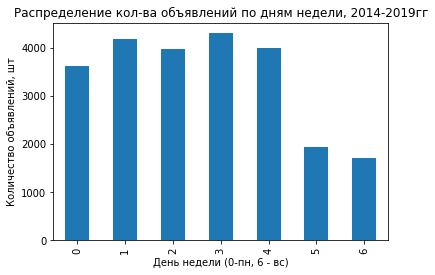

In [64]:
#fixed
# добавим новый столбец с указанием дня недели из даты публикации объявления
data['date_dayofweek'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.dayofweek
data['date_dayofweek'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение кол-ва объявлений по дням недели, 2014-2019гг')
plt.ylabel('Количество объявлений, шт')
plt.xlabel('День недели (0-пн, 6 - вс)')

Text(0.5, 0, 'Месяц года')

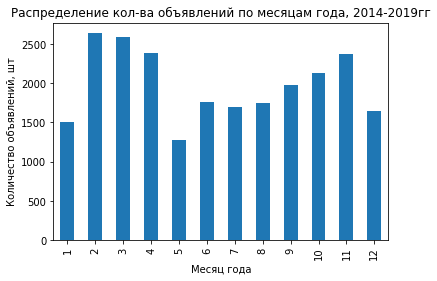

In [65]:
# добавим новый столбец с указанием месяца из даты публикации объявления
data['date_month'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.month
data['date_month'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение кол-ва объявлений по месяцам года, 2014-2019гг')
plt.ylabel('Количество объявлений, шт')
plt.xlabel('Месяц года')

Text(0.5, 0, 'Год')

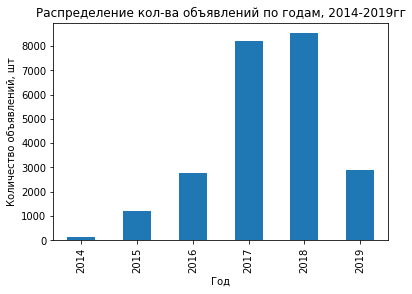

In [66]:
# добавим новый столбец с указанием года из даты публикации объявления
data['date_year'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.year
data['date_year'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение кол-ва объявлений по годам, 2014-2019гг')
plt.ylabel('Количество объявлений, шт')
plt.xlabel('Год')

In [67]:
# добавим качественное описание этажности
def add_category_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['category_floor'] = data.apply(add_category_floor, axis=1)
data['category_floor'].value_counts()

другой       17440
последний     3342
первый        2917
Name: category_floor, dtype: int64

<a id='adding_data_conclusion'></a>
### Вывод по шагу 3

Для проведения дальнейшего анализа интересен будет показатель относительной стоимости квадратного метра, расчетные данные с этой величиной были добавлены в столбец `cost_per_sq_m`.

Дата публикации объявления содержит в себе полную дату и время подачи объявления, но для целей анализа дата в таком формате не совсем удобна, выделили следующие параметры:
* столбец с указанием дня недели - `date_dayofweek`;
* столбец с указанием месяца - `date_month`;
* столбец с указанием года - `date_year`.

Данные с указанием этажа для целей анализа удобнее категоризировать на первый, последний и другой. Данные по категориям добавлены в столбец `category_floor`.

Для заполнения пропусков по жилой площади и площади кухни ранее были расчитаны коэффициенты соотношений данных типов площадей к общей площади недвижимости. Соотношения были добавлены в столбцы `ratio_kitchen_area` и `ratio_living_area`.

<a id='analysis'></a>
### Шаг 4. Исследовательский анализ данных

<a id='numerical_parameter'></a>
#### Шаг 4.1 Изучение числовых параметров: площадь, цена, число комнат, высота потолков

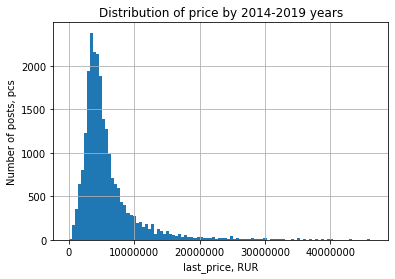

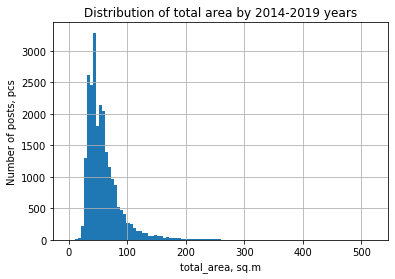

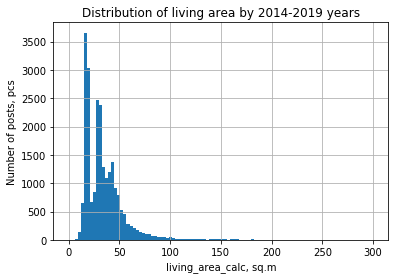

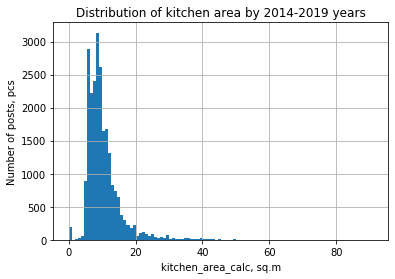

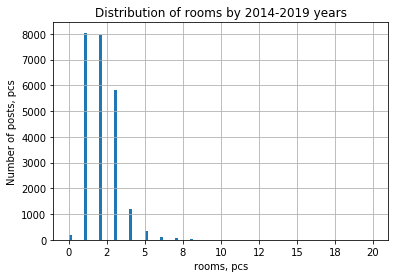

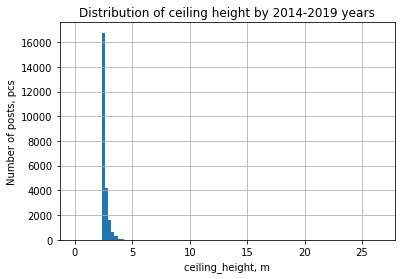

In [68]:
params = ['last_price', 'total_area', 'living_area_calc', 'kitchen_area_calc', 'rooms', 'ceiling_height']
for param in params:
    fig, ax = plt.subplots()
    data.hist(param, bins=100, range=(0, data[param].median()*10), ax = ax)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.ylabel('Number of posts, pcs')
    plt.xlabel('{}, {}'.format(param, dimension.get(param)))
    plt.title('Distribution of {} by 2014-2019 years'.format(titles.get(param)))
    plt.show()

Распределение цен больше остальных похоже на нормальное, но видно, что у данных есть длинный хвост справа, несомненно, каждый хочет продать подороже и ценники стремятся в плюс-бесконечность, но для нас часть этих значений будут являться выбросами. Чтобы убедиться в распределении, рассмотрим далее гистограмму с ограничением, применяемым в диаграмме размаха для границы усов, чтобы отфильтровать выбросы.

Распределение общей площади также очень похоже на нормальное, но смещено влево, и также имеет длинный хвост справа, который попытаемся отфильтровать. Смещение влево может быть обусловлено тем, что значение площадей невозможны меньше определенных значений по своей сути - понятно, что для целей реновации государство очень бы хотело строить квартиры по 5 кв.м, но это противоречит здравому смыслу и санитарным нормам.

Распределения жилой площади и площади кухни имеют чередующиеся высокие и низкие значения, что может быть обусловлено некорректным заполнением части данных в объявлениях, например, погрешности из-за округлений площади. Аналогично общей площади у распределения жилой мы видим смещение влево, что будет обусловлено теми же причинами ограниченности минимальных значений площади.

Количество комнат как дискретная величина сложно поддается описанию с точки зрения нормального распределения, но вполне соответствует ожиданию - почти в любом современном доме квартир с маленьким числом комнат (1-2комнатных) будет подавляющее большинство, что соответствует и спросу, и возможностям большинства людей.

Распределение значений высот потолка имеют высокий пик в районе 2,5 - 3м, что является вполне ожидаемым и укладывается в стандартные нормы, значение серьезно больше или меньше этого пика выглядят как выбросы и ошибки в данных.

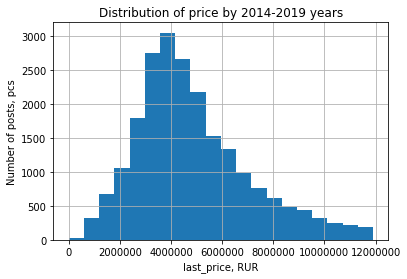

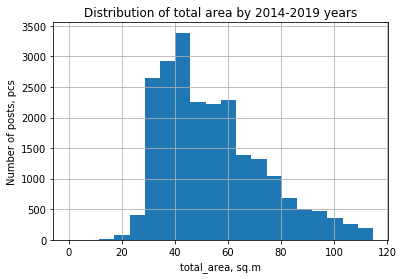

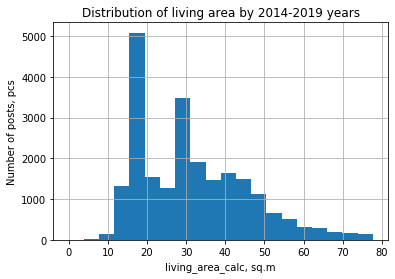

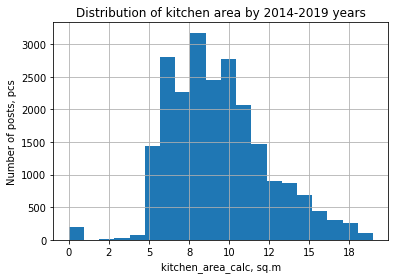

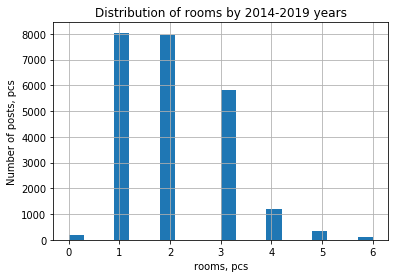

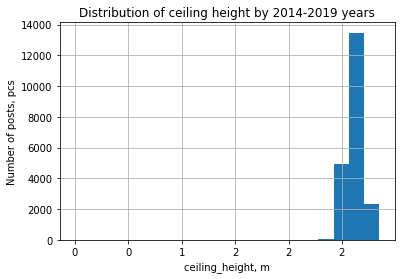

In [69]:
# построим гистограммы, задав ограничение для фильтрования выбросов, чтобы убедиться в выводах
# строим согласно формуле, применяемой в диаграмме размаха
params = ['last_price', 'total_area', 'living_area_calc', 'kitchen_area_calc', 'rooms', 'ceiling_height']
for param in params:
    fig, ax = plt.subplots()
    range_max = data[param].quantile(0.75) + 1.5 * (data[param].quantile(0.75) - data[param].quantile(0.25))
    data.hist(param, bins=20, range=(0, range_max), ax = ax)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.title('Distribution of {} by 2014-2019 years'.format(titles.get(param)))
    plt.xlabel('{}, {}'.format(param, dimension.get(param)))
    plt.ylabel('Number of posts, pcs')
    plt.show()

Действительно, гистограммы, построенные на данных без учета выбросов, позволили убедиться в сделанных выше выводах.

<a id='period'></a>
#### Шаг 4.2 Изучение времени продажи квартиры

Text(0, 0.5, 'Количество объявлений, шт.')

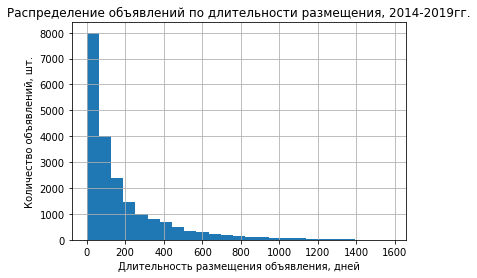

In [70]:
data['days_exposition'].hist(bins=25)
plt.title('Распределение объявлений по длительности размещения, 2014-2019гг.')
plt.xlabel('Длительность размещения объявления, дней')
plt.ylabel('Количество объявлений, шт.')

Распределение времени продажи квартир очень похоже на распределение Пуассона, которое применяется для описания отдельных событий, которые происходят в течение некоторого интервала времени. Графиком и здравым смыслом это подверждается - по большинству объявлений продажи происходили за небольшие промежутки времени, а тех, кто готов был состариться, пока найдется тот самый покупатель - совсем единицы.

Посмотрим, сколько времени занимает типичная продажа, какие продажи будут быстрыми, а какие долгими, посмотрим на график размаха и выведем характеристики.

Text(0, 0.5, 'Количество объявлений, шт.')

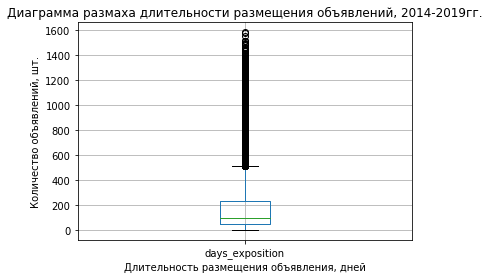

In [71]:
data.boxplot('days_exposition')
plt.title('Диаграмма размаха длительности размещения объявлений, 2014-2019гг.')
plt.xlabel('Длительность размещения объявления, дней')
plt.ylabel('Количество объявлений, шт.')

In [72]:
data['days_exposition'].describe()

count   20518.00
mean      180.89
std       219.73
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

Определим очень быстрые и очень долгие продажи на основании "усов" диаграммы размаха, считая, что нормальные значения будут в пределах "усов" ящика, а те значения, что выйдут за его границы - будут аномальными.

In [73]:
def count_iqr(param):
    iqr = data[param].quantile(0.75) - data[param].quantile(0.25)
    range_max = data[param].quantile(0.75) + 1.5 * iqr
    range_min = max(0, data[param].quantile(0.25) - 1.5 * iqr)
    return [range_min, range_max]

In [74]:
print('Медианное время продажи: {} дней'.format(data['days_exposition'].median()))
print('Среднее время продажи: {} дней'.format(data['days_exposition'].mean().round()))
range_limit = count_iqr('days_exposition')

print('Слишком долгая продажа - это когда объявление висит больше {} дней'.format(range_limit[1].round()))
print('Слишком быстрая продажа - это когда объявление висит меньше {} дней'.format(range_limit[0]))

Медианное время продажи: 95.0 дней
Среднее время продажи: 181.0 дней
Слишком долгая продажа - это когда объявление висит больше 512.0 дней
Слишком быстрая продажа - это когда объявление висит меньше 0 дней


В среднем квартиру удается продать за полгода (181 день), даже если объявление не самое типичное. Если же объявление будет типичным, то скорее всего оно будет закрыто за квартал (95 дней). Слишком долгой продажа становится, когда объявление висит уже почти 1,5 года (512 дней), ну а слишком быстрой продажи не бывает, ведь нет предела к совершенству, хотя для 75% объявлений, не сумевших продать квартиру хотя бы за 45 дней, это не слишком утешительно.

<a id='ejection'></a>
#### Шаг 4.3 Изучение выбросов

Ранее мы увидели, что числовые показатели имеют длинные хвосты, которые наверняка будут являться выбросами. Изучим выбросы в показателях цены, площади, количества комнат, высоты потолков и удаленности от центра с помощью диаграмм размаха 

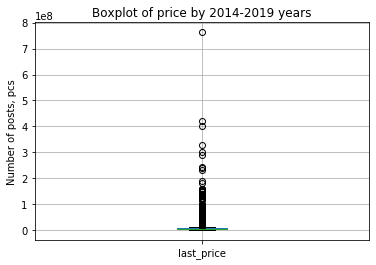

Выбросами для last_price будем считать данные больше 11900000.0 или меньше 0.0 


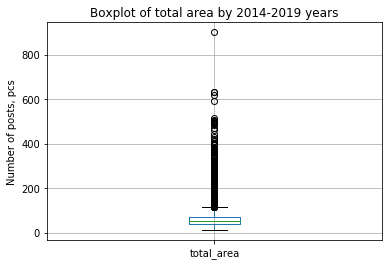

Выбросами для total_area будем считать данные больше 114.8 или меньше 0.0 


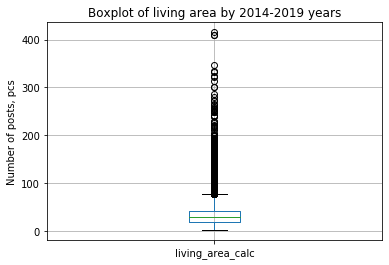

Выбросами для living_area_calc будем считать данные больше 77.7 или меньше 0.0 


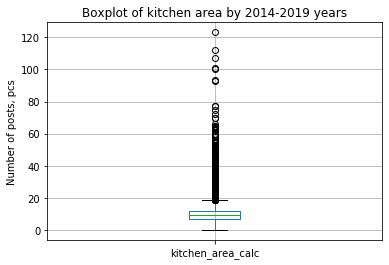

Выбросами для kitchen_area_calc будем считать данные больше 19.0 или меньше 0.0 


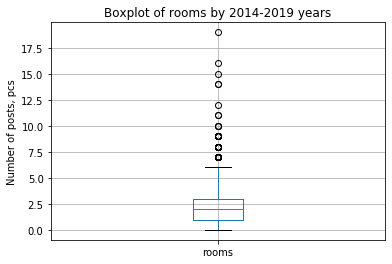

Выбросами для rooms будем считать данные больше 6.0 или меньше 0.0 


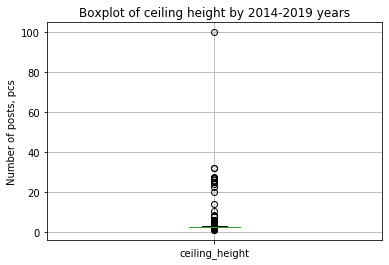

Выбросами для ceiling_height будем считать данные больше 2.9 или меньше 2.5 


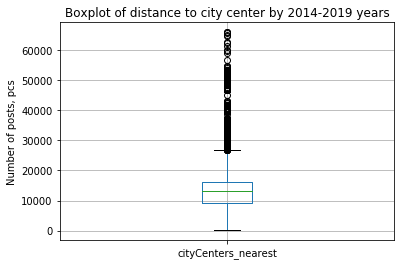

Выбросами для cityCenters_nearest будем считать данные больше 26875.5 или меньше 0.0 


In [75]:
#fixed
params = ['last_price', 'total_area', 'living_area_calc', 'kitchen_area_calc',\
          'rooms', 'ceiling_height', 'cityCenters_nearest']
for param in params:
    data.boxplot(param)
    plt.title('Boxplot of {} by 2014-2019 years'.format(titles.get(param)))
    plt.ylabel('Number of posts, pcs')
    plt.show()
    range_limit = count_iqr(param)
    print('Выбросами для {} будем считать данные больше {:.1f} или меньше {:.1f} '
          .format(param, range_limit[1], range_limit[0]))

Каждый из изученных числовых параметров имеет значительные выбросы правее правого "уса", с большей долей вероятности можно предположить, что в Санкт-Петербурге есть элитная недвижимость, которая значительно отличается от типичных объектов недвижимости по стоимости, метражу и количеству комнат. Возможно, это связано с районом, где находится такая недвижимость или классом постройки. Также в СПб есть особенность, связанная с наличием большого количества коммунальных квартир, число комнат в которых может исчисляться числами второго порядка, а высота потолоков в дореволюционных домах порой достигает 4-5, а иногда даже 9 метров.

In [76]:
# удалим выбросы и сохраним в новую переменную df
df = data.copy()
params = ['last_price', 'total_area', 'living_area_calc', 'kitchen_area_calc',\
          'rooms', 'ceiling_height', 'cityCenters_nearest']
for param in params:
    df = df[df[param] < count_iqr(param)[1]]
    
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,12523.00,9.83,5.53,0.00,6.00,9.00,14.00,32.00
last_price,12523.00,5281879.19,1889819.81,1190000.00,3900000.00,4800000.00,6240000.00,11880000.00
total_area,12523.00,51.81,17.02,12.00,39.00,47.65,62.00,114.20
rooms,12523.00,1.88,0.88,0.00,1.00,2.00,3.00,5.00
ceiling_height,12523.00,2.63,0.08,1.00,2.57,2.65,2.65,2.85
floors_total,12523.00,12.44,6.55,1.00,9.00,10.00,16.00,52.00
living_area,11650.00,29.53,12.15,3.00,18.00,28.70,38.00,77.00
floor,12523.00,6.70,5.19,1.00,3.00,5.00,9.00,33.00
kitchen_area,11361.00,9.27,2.90,0.00,7.00,9.00,11.00,18.90
balcony,12523.00,0.61,0.95,0.00,0.00,0.00,1.00,5.00


Разделим метраж квартир по категориям (каждые 20кв.м) и проанализируем изменение средней цены за кв.м 

Text(0, 0.5, 'Стоимость кв.м, RUR')

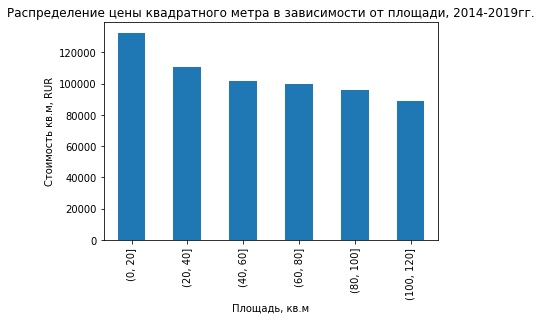

In [77]:
fig, ax = plt.subplots()
(df
.groupby(pd.cut(df['total_area'], [0, 20, 40, 60, 80, 100, 120]))['cost_per_sq_m'].mean()
.plot(kind='bar', ax=ax)
)
plt.title('Распределение цены квадратного метра в зависимости от площади, 2014-2019гг.')
ax.set_xlabel('Площадь, кв.м')
ax.set_ylabel('Стоимость кв.м, RUR')

Наглядно видна тенденция снижения стоимости квадратного метра при увеличении площади объекта.

<a id='dominants'></a>
#### Шаг 4.4 Доминантные факторы

Изучим влияние на цену имущества основных числовых параметров, для этого построим диаграмму рассеяния и посчитаем коэффициент корреляции Пирсона.

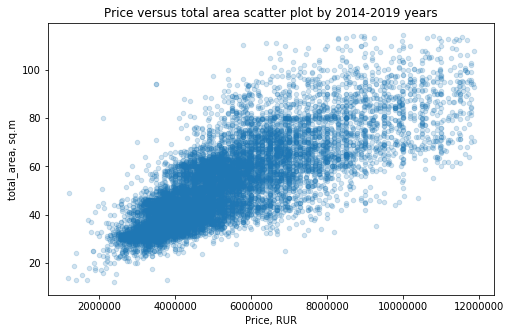

Pearson correlation coefficient: 0.79


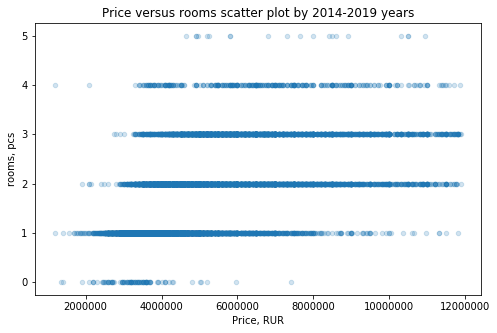

Pearson correlation coefficient: 0.51


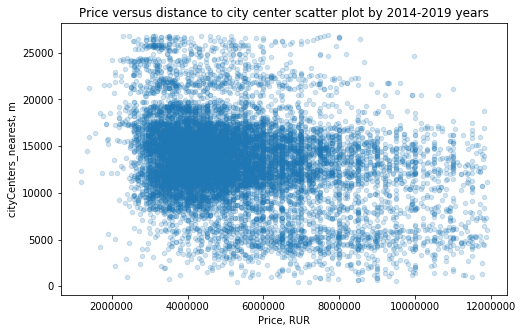

Pearson correlation coefficient: -0.3


In [78]:
params = ['total_area', 'rooms', 'cityCenters_nearest']
for param in params:
    fig, ax = plt.subplots()
    (df
     .plot(x='last_price', y=param, kind='scatter', alpha=0.2, figsize=(8, 5), ax = ax))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.title('Price versus {} scatter plot by 2014-2019 years'.format(titles.get(param)))
    plt.xlabel('Price, RUR')
    plt.ylabel('{}, {}'.format(param, dimension.get(param)))
    plt.show()
    print('Pearson correlation coefficient: {:.2}'.format(df['last_price'].corr(df[param])))

Несомненно, есть довольно сильная прямая зависимость цены от метража объекта, чаще всего на больших метражах цена выше. Но зависимость не является линейной, коэффициент Пирсона на уровне 79% может свидетельствовать о том, что есть и другие факторы, которые достаточно явно вмешиваются и имеют существенное влияние.

От количества комнат цена зависит несильно, это ожидаемо, ведь с одинаковым количеством комнат метраж может различаться в разы, что существенно будет влиять и на стоимость объекта.

Цена противоположно зависит от степени удаленности от центра, хотя в этом случае связь довольно слабая, но все же по графику можно заметить, что объекты с высокими значениями стоимости встречаются чаще при небольшом удалении от центра.

Изучим, влияет ли этаж квартиры на ее стоимость

In [79]:
(df
 .groupby('category_floor')
 .agg({'last_price': ['median', 'mean', 'count'], 'cost_per_sq_m': ['median', 'mean']})
)

last_price                  cost_per_sq_m          
                   median       mean count        median      mean
category_floor                                                    
другой         4900000.00 5388010.05  9888     102272.73 105300.65
первый         4300000.00 4707090.28  1299      90268.46  93058.71
последний      4550000.00 5055254.02  1336      96354.58  99925.05

Text(0.5, 1.0, 'Share of posts by floor category (2014-2019 years)')

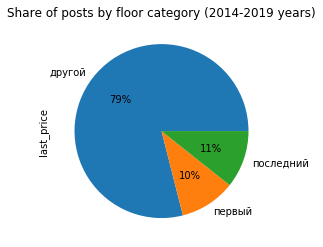

In [80]:
(df
 .groupby('category_floor')['last_price'].count()
 .plot(kind='pie', autopct='%1.f%%')
)
plt.title('Share of posts by floor category (2014-2019 years)')

По количеству объявлений первый и последний этажи занимают примерно одинаковую долю (10% и 11% соответственно), тогда как подавляющее большинство объектов недвижимости расположено на других, не крайних этажах.

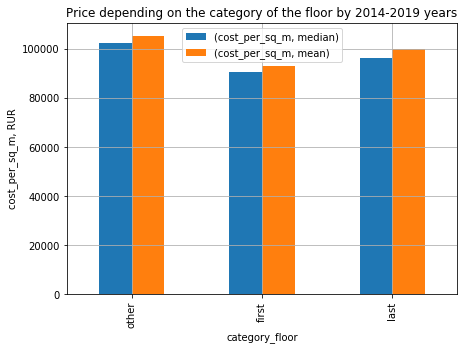

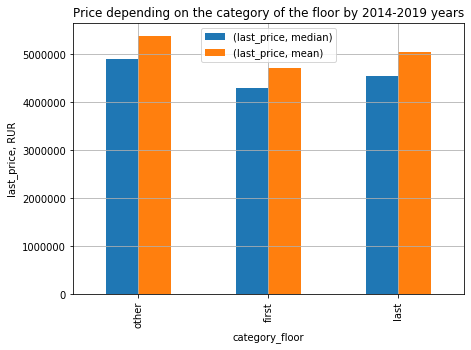

In [81]:
params = ['cost_per_sq_m', 'last_price']
for param in params:
    fig, ax = plt.subplots()
    (df
     .groupby('category_floor')
     .agg({param: ['median', 'mean']})
     .plot(kind='bar', grid=True, figsize=(7, 5), ax=ax)
    )
    ax.set_title('Price depending on the category of the floor by 2014-2019 years')
    ax.set_ylabel('{}, {}'.format(param, dimension.get(param)))
    ax.set_xticklabels(['other', 'first', 'last'])
    ax.legend()

Проанализировав распределение средней и медианной стоимости объектов недвижимости, а также среднюю и медианную стоимости квадратного метра, можно сделать вывод о том, что первый этаж обычно стоит дешевле других на ~10%, последний этаж также оценивается дешевле на 4-5%, чем остальные не крайние.

Рассмотрим, зависит ли стоимость объектов от даты размещения объявления

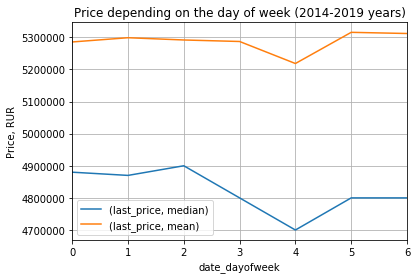

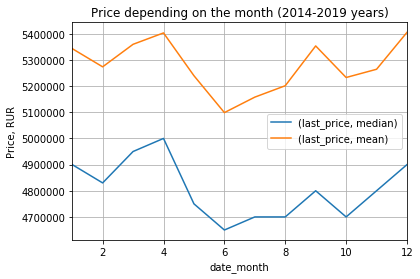

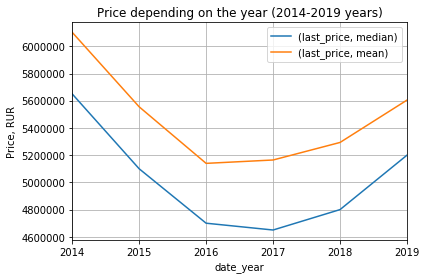

In [82]:
# по общей цене
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    fig, ax = plt.subplots()
    (df
     .groupby(param)
     .agg({'last_price': ['median', 'mean']})
     .plot(grid=True, ax=ax)
    )
    ax.set_title('Price depending on the {} (2014-2019 years)'.format(titles.get(param)))
    ax.set_ylabel('Price, RUR')
    ax.legend()

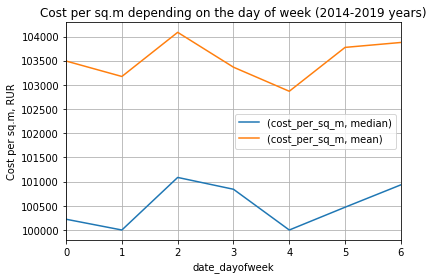

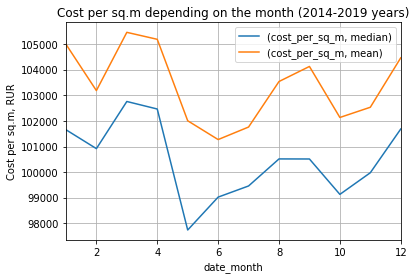

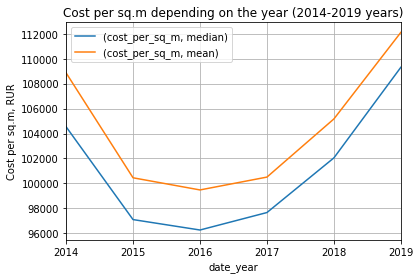

In [83]:
# по цене за кв.м
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    fig, ax = plt.subplots()
    (df
     .groupby(param)
     .agg({'cost_per_sq_m': ['median', 'mean']})
     .plot(grid=True, ax=ax)
    )
    ax.set_title('Cost per sq.m depending on the {} (2014-2019 years)'.format(titles.get(param)))
    ax.set_ylabel('Cost per sq.m, RUR')
    ax.legend()

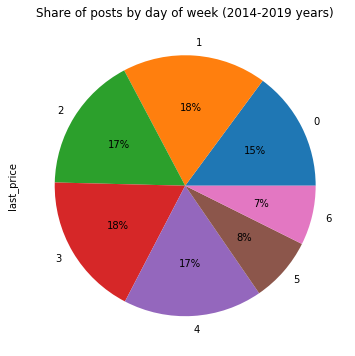

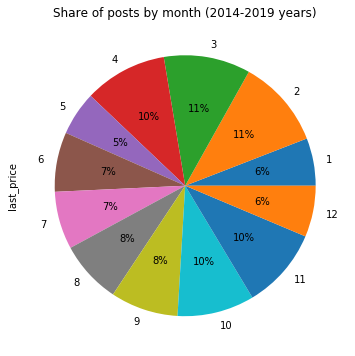

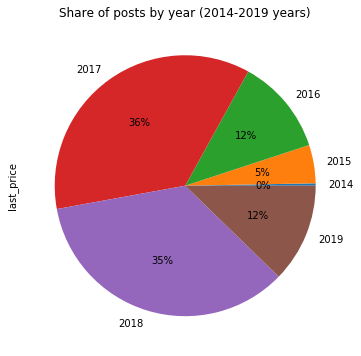

In [84]:
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    (df
         .groupby(param)['last_price'].count()
         .plot(kind='pie', autopct='%1.f%%', figsize=(6,6))
    )
    plt.title('Share of posts by {} (2014-2019 years)'.format(titles.get(param)))
    plt.show()

Если ориентироваться на медианный график стоимости объектов, то зависимости от размещения в какой-либо из дней недели не наблюдается. Объекты недвижимости с самой низкой медианной ценой и стоимостью в расчете на кв.м размещаются в пятницу, а в среднем - в выходные цена за кв.м ниже, в будни - больше. При этом и доля объявлений, которые размещаются в будни, выше (от 15% до 18%), тогда как в выходные их количество почти в 2 раза ниже (7-8%). Можно сделать предположение, что в выходные объявления размещают преимущественно непосредственные владельцы недвижимости, т.к. в будние дни они заняты на работе и не могут уделить достаточно времени написанию объявления, а в будни - преимущественно размещения от риэлторов или других профессиональных участников рынка недвижимости. При этом цена у собственника может быть ниже, т.к. он не владеет информацией по рынку на уровне профессионального или за счет отсутствия риэлторской комиссии. 

По объему объявлений в течение года видим, что наиболее продуктивные месяцы с точки зрения подачи объявлений располагаются в начале (февраль-апрель, 10-11%) и конце (октябрь-ноябрь, 10%) года, обрамляя одни из самых малочисленных - декабрь и январь (по 6%). После довольно высокого апреля видим обрушение объема в 2 раза до 5% в мае, а затем плавное восстановление объема до конца осени. Что же касается уровня цен, то месяц, в котором размещаются более дорогие объекты недвижимости - это апрель, а вот в следующие за ним май и июнь напротив размещались объявления по квартирам с наименьшей медианной ценой за кв.м в рамках года. Это любопытная тенденция, причем подтверждается она и графиком цены объектов и удельной стоимостью кв.м. - в летние месяцы рынок недвижимости несколько проседает и, видимо, чтобы быстрее продать имущество, люди готовы уступать по цене.

График медианной цены объектов и медианных значений стоимости кв.м по годам наглядно демонстрируют спад на рынке недвижимости после 2014 года, произошедший на фоне общего экономического спада, основным ограничивающим фактором стали доходы населения и дальнейшие кризисные ожидания, когда люди предпочитали откладывать дорогостоящие покупки до лучших времен. Начиная с 2017 года экономика стала восстанавливаться и на рынке недвижимости мы также видим рост и в объеме (36% и 38% в 2017 и 2018гг) и снова начался рост стоимости объектов, но медианное значение цены 2019г пока все равно остается ниже того же показателя 2014г, хотя средняя стоимость кв.м уже почти достигло докризисных величин, а медианная даже превысила.

<a id='locality'></a>
#### Шаг 4.5 Изучение по населенным пунктам

Рассмотрим стоимость квадратного метра в зависимости от локации

In [85]:
(data[data['last_price'] < count_iqr('last_price')[1]]
 .pivot_table(index='locality_name_short', values='cost_per_sq_m', aggfunc=['median', 'count'])
 .sort_values([('count', 'cost_per_sq_m')], ascending=False)
 .head(10)
 .sort_values([('median', 'cost_per_sq_m')], ascending=False)
)

,median,count
,cost_per_sq_m,cost_per_sq_m
locality_name_short,,
Санкт-Петербург,101865.14,13737
Пушкин,98325.89,338
Кудрово,95555.31,470
Парголово,91642.86,327
Мурино,86175.64,590
Шушары,76876.17,440
Колпино,74689.88,336
Гатчина,67695.96,305


Среди 10 популярных населенных пунктов с самым большим количеством объявлений наибольшая стоимость квадратного метра - в Санкт-Петербурге (101,9 тыс.руб. за кв.м), наименьшая стоимость - в Выборге (58,1 тыс.руб. за кв.м), что на 57% ниже, чем в областном центре. Логично, что в самом Петербурге и его округе стоимость кв.м оценивается выше, тогда как областные районы не так котируются и поэтому стоимость кв.м в них значительно ниже. 

<a id='distance'></a>
#### Шаг 4.6 Изучение предложения квартир

Есть предположение, что не только расположение объекта в области или в городе влияет на цену, скорее всего, стоимость квартир в центре города выше, чем в остальных районах, проверим эту гипотезу, выделив радиус, описывающий центр СПб.

In [86]:
df.query('"Санкт-Петербург" in locality_name_short')['cityCenters_nearest'].describe()

count   11762.00
mean    12916.88
std      4088.39
min       399.00
25%     10916.00
50%     13204.00
75%     15442.00
max     26286.00
Name: cityCenters_nearest, dtype: float64

Все объекты с локацией "Санкт-Петербург" находятся в пределах 26км от центра города, а каждое типичное объявление с продажей объекта недвижимости в СПб находится в пределах 13 км.

Text(0.5, 0, 'Удаленность от центра, км')

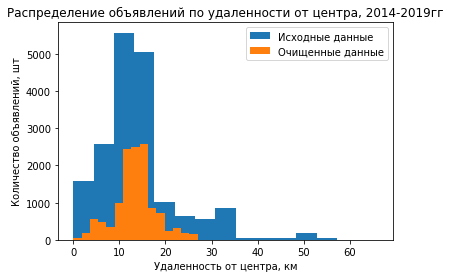

In [87]:
#fixed
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round()
df['cityCenters_nearest_km'] = (df['cityCenters_nearest']/1000).round()
fig, ax = plt.subplots()
data['cityCenters_nearest_km'].plot(kind='hist', bins=15, ax=ax, label='Исходные данные')
df['cityCenters_nearest_km'].plot(kind='hist',bins=15, ax=ax, label='Очищенные данные')
plt.legend()
ax.set_title('Распределение объявлений по удаленности от центра, 2014-2019гг')
ax.set_ylabel('Количество объявлений, шт')
ax.set_xlabel('Удаленность от центра, км')

Гистограммы удаленности от центра в км по изначальному и отфильтрованному датафреймам схожи по типу распределения, проведем дальнейшее изучение отдаленности по датафрейму с отфильтрованными выбросами.

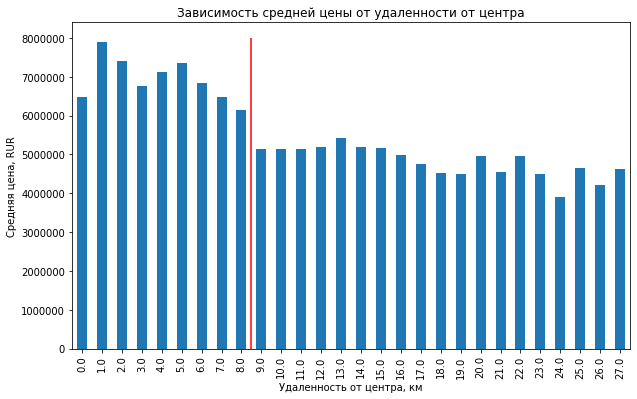

In [88]:
# по отфильтрованному df
fig, ax = plt.subplots()
(df
.groupby('cityCenters_nearest_km')['last_price'].mean()
 .plot(kind='bar', figsize=(10,6), ax=ax)
)
plt.title('Зависимость средней цены от удаленности от центра')
ax.set_xlabel('Удаленность от центра, км')
ax.set_ylabel('Средняя цена, RUR')
ax.vlines(8.5, 0, 8000000, color='r')

На границе 8 и 9 км видно, как средняя стоимость объектов резко снижается. Будем считать 9км порогом, который очерчивает центральную зону города.

<a id='center'></a>
#### Шаг 4.7 Изучение сегмента квартир в центре

In [89]:
data_cityCenters = df[df['cityCenters_nearest_km'] < 9]
data_cityCenters.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,1585.00,9.20,5.52,0.00,5.00,9.00,13.00,32.00
last_price,1585.00,6839671.82,2216266.89,1686000.00,5150000.00,6650000.00,8500000.00,11879250.00
total_area,1585.00,58.90,19.83,12.00,43.40,57.00,72.00,114.20
rooms,1585.00,2.06,0.90,0.00,1.00,2.00,3.00,5.00
ceiling_height,1585.00,2.66,0.08,2.40,2.65,2.65,2.65,2.85
floors_total,1585.00,8.68,4.90,2.00,5.00,7.00,11.00,28.00
living_area,1454.00,33.92,14.42,6.00,20.78,32.00,43.58,77.00
floor,1585.00,4.77,3.52,1.00,2.00,4.00,6.00,23.00
kitchen_area,1398.00,10.03,3.27,2.00,7.50,9.80,12.00,18.70
balcony,1585.00,0.39,0.78,0.00,0.00,0.00,0.00,5.00


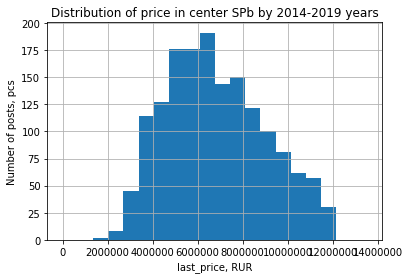

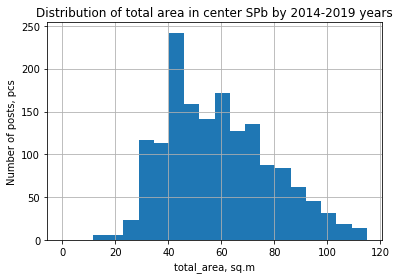

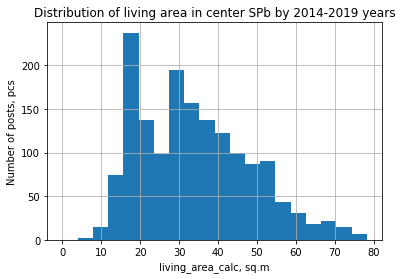

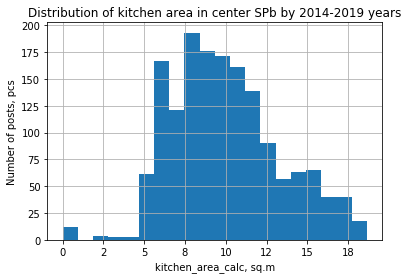

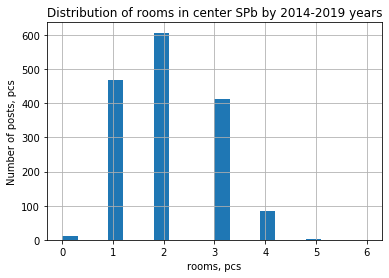

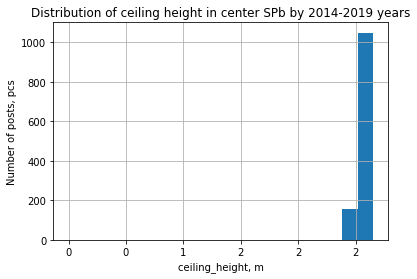

In [90]:
params = ['last_price', 'total_area', 'living_area_calc', 'kitchen_area_calc', 'rooms', 'ceiling_height']
for param in params:
    fig, ax = plt.subplots()
    range_max = data_cityCenters[param].quantile(0.75)\
                + 1.5 * (data_cityCenters[param].quantile(0.75)\
                - data_cityCenters[param].quantile(0.25))
    data_cityCenters.hist(param, bins=20, range=(0, range_max), ax = ax)
    #data_cityCenters.hist(param, bins=100, range=(0, data_cityCenters[param].median()*10), ax = ax, figsize=(10, 8))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.title('Distribution of {} in center SPb by 2014-2019 years'.format(titles.get(param)))
    ax.set_xlabel('{}, {}'.format(param, dimension.get(param)))
    ax.set_ylabel('Number of posts, pcs')
    plt.show()

In [91]:
all_prices_list = []
city_prices_corr_list = []
params = ['last_price', 'cost_per_sq_m']

for param in params:
    all_prices_list.append(df[param].median())
    city_prices_corr_list.append(data_cityCenters[param].median())

prices = pd.DataFrame({'All': all_prices_list, 'City center': city_prices_corr_list}) 
prices.set_index([pd.Index(params)], inplace=True)
prices

,All,City center
last_price,4800000.00,6650000.00
cost_per_sq_m,100356.29,116129.03


Несмотря на то, что выборка стала меньше, графики получились более сглаженными, видимо, сказывается более однородная структура объектов, входящих в выбранную зону. 

Распределение цен объектов хоть и имеет такой же длинный хвост справа, теперь еще сильнее напоминает нормальное распределение, график получился более симметричным за счет того, что средняя стоимость квартир сместилась вправо, и если в целом по выборке стоимость типичного объекта составляла 4,8 млн.руб., то в центральной части это значение уже почти на 40% больше и составляет 6,65 млн. Стоимость квадратного метра также выше в центральной части (+16%). 

Графики площадей также стали более однородными и также пик сместился вправо, хотя до сих пор наблюдается смещение распределения влево в силу описываемых ранее причин. Видим, что типичная квартира в центре и больше по площади - 59 кв.м. против 52 кв.м по всем объектам, хоть прирост и не такой значительный, как разница в цене.

График количества комнат тоже стал больше похож на нормальное распределение, и здесь мы видим, что в центре в большей степени продают 2х-комнатные квартиры, а одно- и трехкомнатные сопоставимы по объемам, что сильно отличается от массы предложений одно- и двухкомнатных квартир в целом по региону. 

Средняя высота потолков по квартирам в центре сравнима с высотой в среднем по региону.

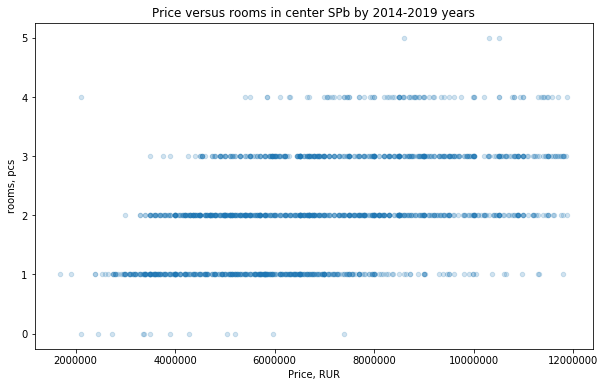

Pearson correlation coefficient: 0.46


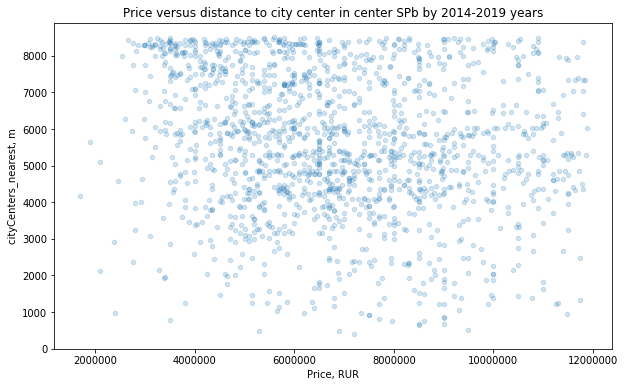

Pearson correlation coefficient: -0.18


In [92]:
params = ['rooms', 'cityCenters_nearest']
for param in params:
    fig, ax = plt.subplots()
    (data_cityCenters
     .plot(x='last_price', y=param, kind='scatter', alpha=0.2, figsize=(10, 6), ax=ax))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.title('Price versus {} in center SPb by 2014-2019 years'.format(titles.get(param)))
    ax.set_xlabel('Price, RUR')
    ax.set_ylabel('{}, {}'.format(param, dimension.get(param)))
    plt.show()
    print('Pearson correlation coefficient: {:.2}'.format(data_cityCenters['last_price'].corr(data_cityCenters[param])))

Сравним коэффициенты корреляции для всего объема и центральной зоны.

In [93]:
all_corr_list = []
city_center_corr_list = []
params = ['total_area', 'rooms', 'cityCenters_nearest']

for param in params:
    all_corr_list.append(df['last_price'].corr(df[param]))
    city_center_corr_list.append(data_cityCenters['last_price'].corr(data_cityCenters[param]))

correlations = pd.DataFrame({'All': all_corr_list, 'City center': city_center_corr_list}) 
correlations.set_index([pd.Index(params)], inplace=True)
correlations

,All,City center
total_area,0.79,0.74
rooms,0.51,0.46
cityCenters_nearest,-0.30,-0.18


В целом корреляционные связи между параметрами, влияющими на цену, почти повторяют картину по всему региону, но в центре города выражены несколько слабее. Сильнее всего выражена прямая зависимость цены и общей площади объекта. Цена на квартиры в центре города также прямо зависит от количества комнат, но как и по всему региону, эта связь не очень сильно выражена. Удаленность от центра слабо влияет на стоимость - в радиусе 8км все объекты котируются приблизительно в одном ценовом диапазоне.

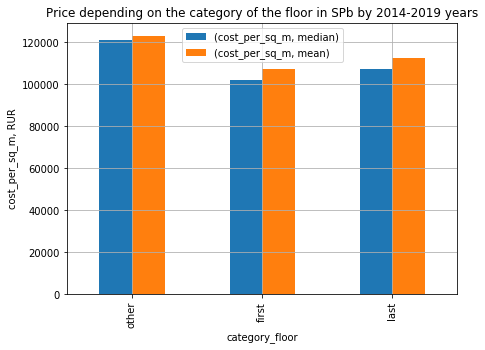

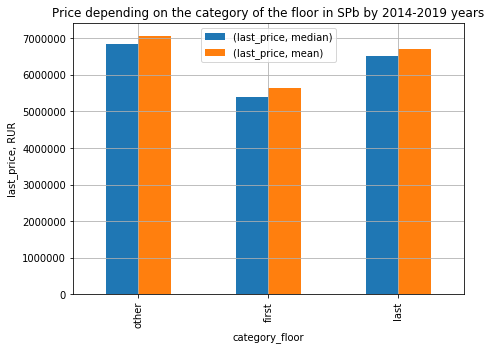

In [94]:
params = ['cost_per_sq_m', 'last_price']
for param in params:
    fig, ax = plt.subplots()
    (data_cityCenters
     .groupby('category_floor')
     .agg({param: ['median', 'mean']})
     .plot(kind='bar', grid=True, figsize=(7, 5), ax=ax)
    )
    ax.set_title('Price depending on the category of the floor in SPb by 2014-2019 years')
    ax.set_ylabel('{}, {}'.format(param, dimension.get(param)))
    ax.set_xticklabels(['other', 'first', 'last'])
    ax.legend()

Text(0.5, 1.0, 'Share of posts by floor category in SPb (2014-2019 years)')

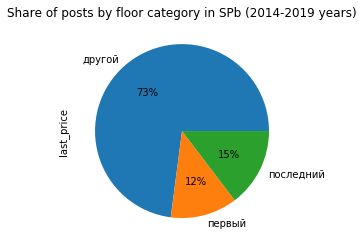

In [95]:
(data_cityCenters
 .groupby('category_floor')['last_price'].count()
 .plot(kind='pie', autopct='%1.f%%')
)
plt.title('Share of posts by floor category in SPb (2014-2019 years)')

Сделанный ранее вывод о том, что квартиры на первом и последнем этажах стоят дешевле, подтверждается и на выборке объектов в центре города - и по показателю общей стоимости, и по относительной стоимости кв.м.  При этом видно, что доли квартир, расположенные на 1 этаже, примерно соответствуют доле в целом по региону, а вот у квартир на последних этажах заметное отличие в доле  - если в целом по региону объекты на последних этажах составляют 11%, то в центре города их уже 15%, что может говорить о том, что в центре города последние этажи имеют свои особенности, значимые для покупателей. Возможно, сказывается специфика самих зданий - могут встречаться мансардные этажи, нередко с более высокими потолками, чем по объектам, расположенным на других этажах.

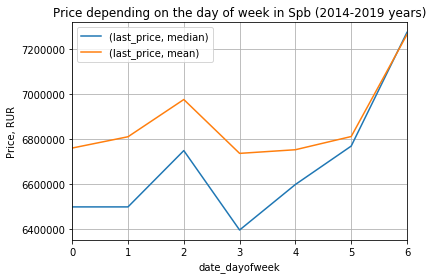

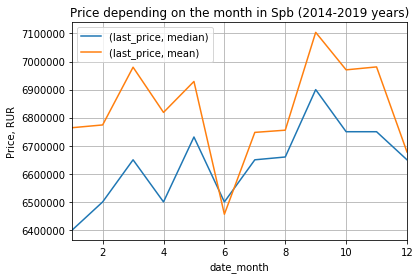

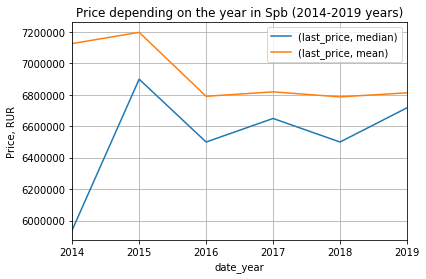

In [96]:
# по общей цене
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    fig, ax = plt.subplots()
    (data_cityCenters
     .groupby(param)
     .agg({'last_price': ['median', 'mean']})
     .plot(grid=True, ax=ax)
    )
    ax.set_title('Price depending on the {} in Spb (2014-2019 years)'.format(titles.get(param)))
    ax.set_ylabel('Price, RUR')
    ax.legend()

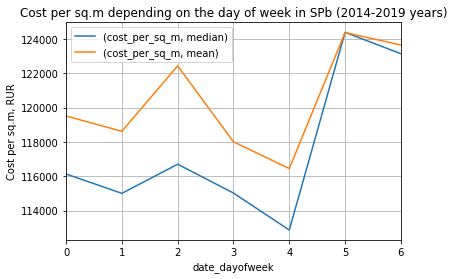

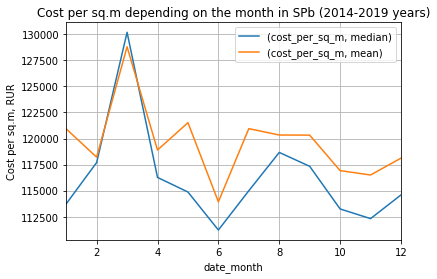

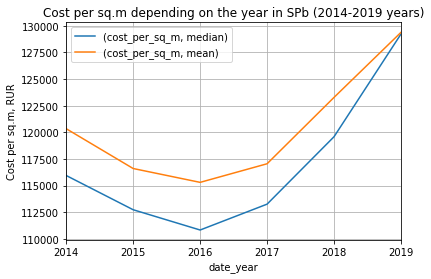

In [97]:
# по цене за кв.м
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    fig, ax = plt.subplots()
    (data_cityCenters
     .groupby(param)
     .agg({'cost_per_sq_m': ['median', 'mean']})
     .plot(grid=True, ax=ax)
    )
    ax.set_title('Cost per sq.m depending on the {} in SPb (2014-2019 years)'.format(titles.get(param)))
    ax.set_ylabel('Cost per sq.m, RUR')
    ax.legend()


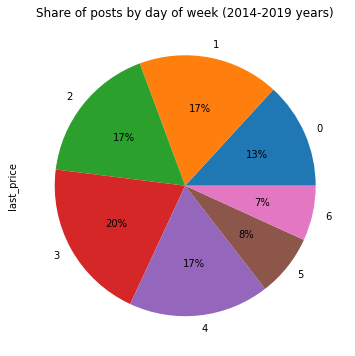

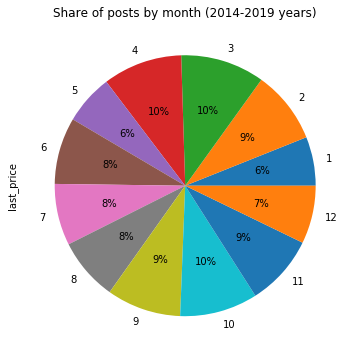

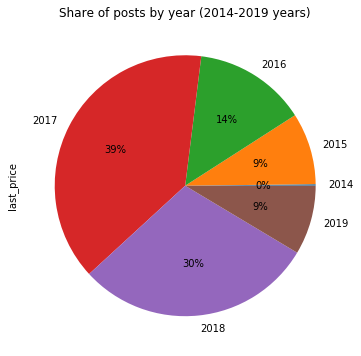

In [98]:
params = ['date_dayofweek', 'date_month', 'date_year']
for param in params:
    (data_cityCenters
         .groupby(param)['last_price'].count()
         .plot(kind='pie', autopct='%1.f%%', figsize=(6,6))
    )
    plt.title('Share of posts by {} (2014-2019 years)'.format(titles.get(param)))
    plt.show()

Медианные значения стоимости объектов не дают выявить какую-то внятную зависимость от дня недели и месяца размещения объявления, единственное, на всех графиках наблюдается провал в середине года. Графики зависимости цены от года объявления демонстрируют несколько иную картину, чем в целом по региону - в центральной части стоимость квадратного метра хоть и снижалась вплоть до 2016г, но затем показала значительный рост в последние годы, опережая тенденции в целом по региону.
Распределение долей по дням недели, месяцам и годам демонстрируют аналогичную всей выборке тенденцию.

Text(0, 0.5, 'Стоимость кв.м, RUR')

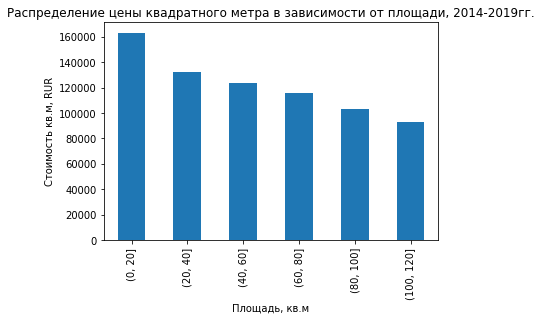

In [99]:
fig, ax = plt.subplots()
(data_cityCenters
.groupby(pd.cut(data_cityCenters['total_area'], [0, 20, 40, 60, 80, 100, 120]))['cost_per_sq_m'].mean()
.plot(kind='bar', ax=ax)
)
plt.title('Распределение цены квадратного метра в зависимости от площади, 2014-2019гг.')
ax.set_xlabel('Площадь, кв.м')
ax.set_ylabel('Стоимость кв.м, RUR')

Анализ стоимости квадратного метра по очищенным от выбросов данным демонстрирует снижение удельной цены квадратного метра при увеличении площади объекта, эту же тенденцию мы видели ранее и на общих данных.

<a id='analysis_conclusion'></a>
### Вывод по шагу 4

При анализе недвжимости в центральной зоне СПб были увидены общие закономерности - традиционно первый и последний этажи стоят дешевле, стоимость квадратного метра снижается с увеличением площади объекта, а цены в рамках годовых периодов подчиняются общеэкономическим тенденциям на рынке. 
Но несмотря на то, что типы распределения факторов схожи с тем, что мы видели по всей выборке, объекты недвижимости в центре города имеют свою специфику - сами объекты стоят дороже, метраж и количество комнат больше, доля продаж на последних этажах выше. Учитывая, что в центральной исторической части города находятся преимущественно дореволюционные здания, становится очевидно, насколько понятие нормальных и типичных условий для жизни претерпели девальвацию за последние несколько десятков лет.

<a id='total_conclusion'></a>
### Шаг 5. Общий вывод

Почти все изученные числовые параметры (цена, метраж, высота потолков, удаленность от центра) имеют значительные выбросы, частично объяснимые неоднородностью рынка недвижимости и его динамичной структурой за счет влияния на него множества факторов. Неоднородность выражается и в наличии элитной недвижимости с большим количеством комнат, большим метражом и соответственно значительной стоимостью, и в том, что районы даже внутри города неодинаково оцениваются участниками рынка - центр города довольно сильно выделяется на фоне остальных объявлений, и это стоит учитывать в дальнейшем при построении модели определения рыночной стоимости недвижимости. Также в СПб есть особенность, связанная с наличием большого количества коммунальных квартир, число комнат в которых может исчисляться числами второго порядка, а высота потолоков в дореволюционных домах порой достигает 4-5, а иногда даже 9 метров.

При этом стоит заметить, что типичное объявление о продаже недвижимости закрывается за квартал, в среднем же  даже с учетом выбросов квартира продается за полгода. Если объявление висит дольше, то скорее всего, цена на недвижимость находится не в равновесии с рынком.

Наиболее значимым параметром, влияющим на цену объекта, является метраж - после удаления выбросов мы видим довольно сильную прямую зависимость, и также видим обратную зависимость стоимости квадратного метра от общей площади. Количество комнат влияет весьма опосредованно, ведь метраж квартир с одинаковым количеством комнат может различаться в разы. Действительно, клиенты не готовы платить за номинальное количество комнат, особенно если их будет 20 на 20ти квадратных метрах, а вот за каждый дополнительный квадратный метр - вполне. Еще одним немаловажным фактором явлется этаж, на котором расположен объект недвижимости, и если традиционно первые этажи стоят дешевле (порядка 10%), то в процессе анализа мы убедились, что дешевле оцениваются и последние этажи, хоть и разница в цене с остальными, не крайними этажами, составляет всего 4-5%.

При построении модели также несомненно стоит ориентироваться на общеэкономическую ситуацию в стране, законы спроса и предложения никто не отменял, и в случае очередных колебаний рынка руководствоваться ценами предыдущих периодов будет неразумно. Также стоит обратить внимание на тенденцию проседания рынка в летние месяцы, что  сказывается на стоимости объектов недвижимости, и если будет стоять задача продать объект побыстрее, то снижение цены будет являться целевой стратегией.